# Inferring Cosmo from PM Simulation

In [15]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# import jax; print(jax.__file__)
# !nvidia-smi

feynmangpu04.cluster.local
gpu [cuda(id=0)]


In [2]:
!pip install -e .

Obtaining file:///feynman/home/dphp/hs276503/workspace
ERROR: file:///feynman/home/dphp/hs276503/workspace does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
from montecosmo.utils import interfaces

ModuleNotFoundError: No module named 'montecosmo'

In [3]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' #NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

import jax
from jax import random
import jax.numpy as jnp
import jax_cosmo as jc
# import astropy.units as u

import numpyro
# numpyro.set_platform("gpu")
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk, cic_compensation
# import haiku as hk

from jaxpm.painting import cic_paint, cic_read
from jaxpm.utils import gaussian_smoothing, power_spectrum

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

## Probabilistic Model

In [30]:
def linear_pk_interp(cosmology, scale_factor=1, n_interp=256):
  """
  Return a light emulation of the linear matter power spectrum
  """
  k = jnp.logspace(-4, 1, n_interp)
  pk = jc.power.linear_matter_power(cosmology, k, a=scale_factor)
  pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
  return pk_fn


def linear_field(mesh_size, box_size, pk):
  """
  Generate initial conditions.
  """
  kvec = fftk(mesh_size)
  kmesh = sum((kk / box_size[i] * mesh_size[i])**2 for i, kk in enumerate(kvec))**0.5
  pkmesh = pk(kmesh) * (mesh_size.prod() / box_size.prod())

  field = numpyro.sample('init_mesh_base', dist.Normal(jnp.zeros(mesh_size), jnp.ones(mesh_size)))

  field = jnp.fft.rfftn(field) * pkmesh**0.5
  field = jnp.fft.irfftn(field)
  return field


def cosmo_prior(): # TODO: pass mean cosmology
  """
  Defines a cosmological prior to sample from.
  """
  Omega_c_base = numpyro.sample('Omega_c_base', dist.TruncatedNormal(0,1, low=-1))
  sigma8_base = numpyro.sample('sigma8_base', dist.Normal(0, 1))
  Omega_c = numpyro.deterministic('Omega_c', Omega_c_base * 0.2 + 0.25)
  sigma8 = numpyro.deterministic('sigma8', sigma8_base * 0.14 + 0.831)

  cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
  return cosmology

# from numpyro.infer.reparam import LocScaleReparam
# def cosmo_prior():
#   """
#   Defines a cosmological prior to sample from.
#   """
#   reparam_config = {'Omega_c': LocScaleReparam(centered=0),
#                     'sigma8': LocScaleReparam(centered=0)}
#   with numpyro.handlers.reparam(config=reparam_config):
#     Omega_c = numpyro.sample('Omega_c', dist.Normal(0.25, 0.2**2))
#     sigma8 = numpyro.sample('sigma8', dist.Normal(0.831, 0.14**2))

#   cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
#   return cosmology

In [31]:
def forward_model(box_size, mesh_size, scale_factor_lpt, galaxy_density):
  """
  Numpyro forward model.
  """
  # Sample cosmology
  cosmology = cosmo_prior()

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=256)
  init_mesh = linear_field(mesh_size, box_size, pk_fn)
  init_mesh = numpyro.deterministic('init_mesh', init_mesh)

  # Create regular grid of particles
  particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])
  
  # Initial displacement with LPT
  cosmology._workspace = {}  # FIXME: this a temporary fix
  dx, p, f = lpt(cosmology, init_mesh, particles_pos, a=scale_factor_lpt)
  # NOTE: lpt supposes given mesh follows linear pk at a=1, and correct by growth factor to get forces at wanted scale factor.
  particles_pos = particles_pos + dx

  # Cloud In Cell painting
  lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
  lpt_mesh = numpyro.deterministic('lpt_mesh', lpt_mesh)
  # Compensate for CIC painting convolution
  lpt_kmesh = jnp.fft.rfftn(lpt_mesh)
  lpt_kmesh = lpt_kmesh * cic_compensation(fftk(mesh_size))
  lpt_comp_mesh = jnp.fft.irfftn(lpt_kmesh)
  numpyro.deterministic('lpt_comp_mesh', lpt_comp_mesh)

  # Observe
  ## Direct observation
  # lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Delta(lpt_mesh))
  ## Normal noise 
  # lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Normal(lpt_mesh, 0.1))
  ## Poisson noise
  gxy_intens_mesh = numpyro.deterministic(
    'gxy_intens_mesh', (lpt_mesh + 1) * (galaxy_density * box_size.prod() / mesh_size.prod()))
  lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Poisson(gxy_intens_mesh))
  return lpt_mesh_obs

cell_lengths=[10.0, 10.0, 10.0] Mpc/h
k_nyquist=0.31416 h/Mpc, delta_k=0.01963 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


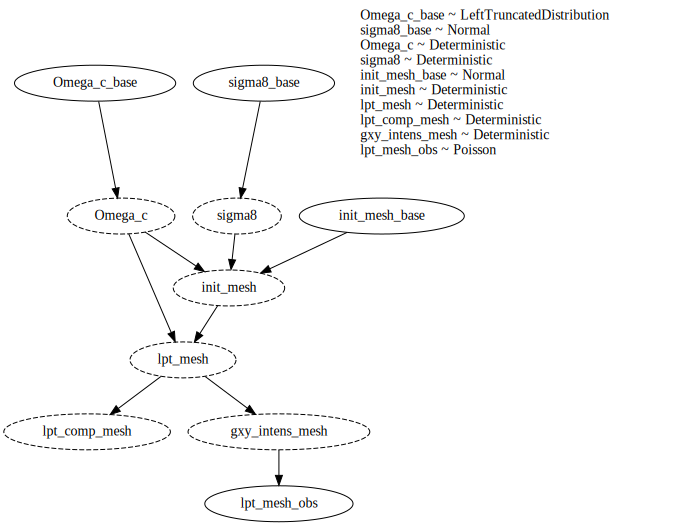

In [32]:
# Model params
model_kwargs = {}

## Mesh and box parameters
mesh_length = 32 # 64
box_length = 320 # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
model_kwargs['mesh_size'] = np.array([mesh_length, mesh_length, mesh_length])
model_kwargs['box_size'] = np.array([box_length, box_length, box_length])  # in Mpc/h

## Scale factor
model_kwargs['scale_factor_lpt'] = 0.1

## Galaxies
model_kwargs['galaxy_density'] = 1e-3 # in galaxy / (Mpc/h)^3

# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(
    model=forward_model,
    model_kwargs=model_kwargs,
    render_distributions=True,
    render_params=True,)

## Simulate

In [33]:
# Choose a cosmology
Omega_c, sigma8 = 0.25, 0.831
fiducial_cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
print(fiducial_cosmology)

# Condition model on cosmology and sample
fiducial_model = condition(forward_model, {"Omega_c_base": 0., "sigma8_base": 0.}) # remember this is reparamd
# fiducial_model = seed(condition(forward_model, {"Omega_c": Omega_c, "sigma8": sigma8}), rng_seed=jax.random.PRNGKey(0)) 

fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
init_mesh, lpt_comp_mesh = fiducial_model_trace['init_mesh']['value'], fiducial_model_trace['lpt_comp_mesh']['value']
print(fiducial_model_trace['sigma8_base']['value'])
print(fiducial_model_trace['Omega_c_base']['value'])
print(fiducial_model_trace['sigma8']['value'])
print(fiducial_model_trace['Omega_c']['value'])

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


0.0
0.0
0.831
0.25


## Power spectra

In [138]:
# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
pk_lpt = power_spectrum(lpt_comp_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

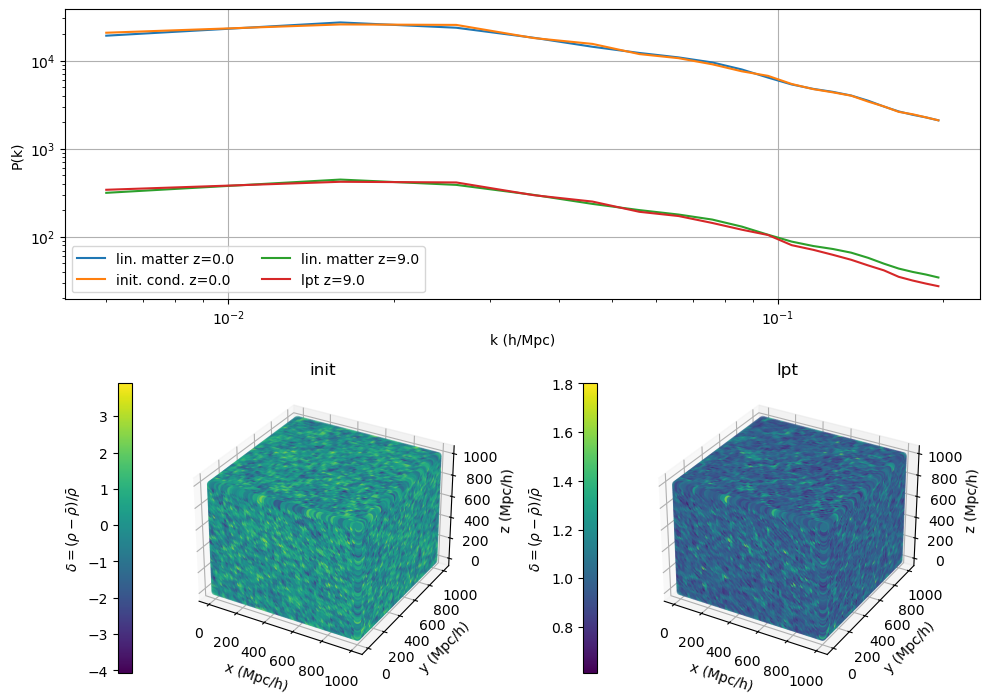

In [139]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"lin. matter z={1/1-1}")
plt.loglog(pk_init[0], pk_init[1], label=f"init. cond. z={1/1-1}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1}")
plt.loglog(pk_lpt[0], pk_lpt[1], label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1}")
plt.grid(), plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")

# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
init_color = init_mesh.flatten()
lpt_color = lpt_comp_mesh.flatten()
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(223, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta = (\rho - \bar \rho) / {\bar \rho}$")
plt.title("init")

ax3D = plt.subplot(224, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta = (\rho - \bar \rho) / {\bar \rho}$")
plt.title("lpt")

plt.tight_layout(), plt.show();

## Inference

In [119]:
from functools import partial
# Condition model
lpt_mesh_obs = fiducial_model_trace['lpt_mesh_obs']['value']
observed_model = condition(forward_model, {'lpt_mesh_obs': lpt_mesh_obs})

# Initialize sampler
init_values = {key: fiducial_model_trace[key]['value'] for key in ['Omega_c_base', 'sigma8_base', 'init_mesh']}

nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    init_strategy=partial(numpyro.infer.init_to_value, values=init_values),
    max_tree_depth=3, # 3
    # inverse_mass_matrix=inverse_mass_matrix, adapt_mass_matrix=False,
    step_size=0.01, adapt_step_size=False
    )

mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=1,
       num_samples=100, # for each run
    #    chain_method="vectorized", 
    #    num_chains=8,
       progress_bar=True)

In [120]:
mcmc.run(random.PRNGKey(0), **model_kwargs)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
  0%|          | 0/101 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getat

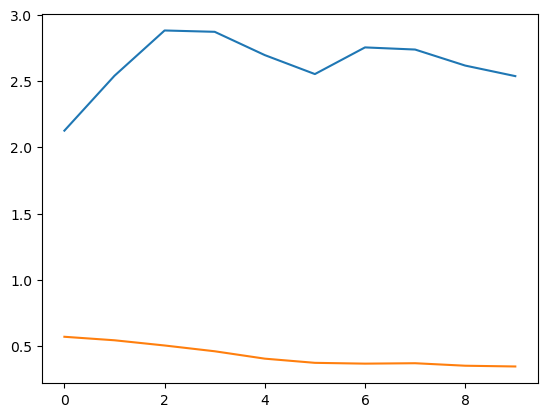

In [123]:
samples = mcmc.get_samples()
plt.plot(samples['Omega_c'][:10])
plt.plot(samples['sigma8'][:10])
plt.show()

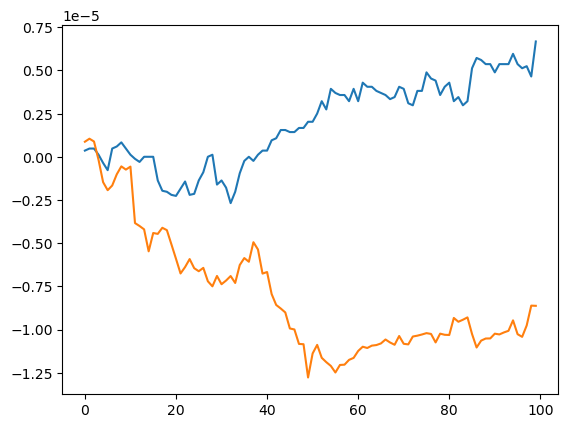

In [ ]:
samples = mcmc.get_samples()
plt.plot(samples['Omega_c_base'])
plt.plot(samples['sigma8_base'])
plt.show()

In [105]:
# Variables to save
save_var_names = ['Omega_c', 'sigma8', 'Omega_c_base', 'sigma8_base']
# Saves directory
save_directory = os.path.expanduser("~/scratch/npys/") # or in "~/work/npys/"
save_name = "to_del_samples"
# Number of runs
n_runs = 1


# Warmup sampling
mcmc.warmup(random.PRNGKey(0), collect_warmup=True, **model_kwargs)
warmup_samples = mcmc.get_samples()
warmup_samples = {key: warmup_samples[key] for key in save_var_names}
inverse_mass_matrix = mcmc.last_state.adapt_state.inverse_mass_matrix
# Saving warmup
save_path = os.path.join(save_directory, save_name+f"_{0}")
np.save(save_path, warmup_samples)
del warmup_samples

# Run sampling
for i_run in range(1, n_runs+1):
    print(f"run {i_run}/{n_runs}")
    
    # Init run at previous state
    mcmc.post_warmup_state = mcmc.last_state
    
    # Run
    mcmc.run(mcmc.post_warmup_state.rng_key, **model_kwargs)
    run_samples = mcmc.get_samples()
    run_samples = {key: run_samples[key] for key in save_var_names}
    
    # Saving run
    save_path = os.path.join(save_directory, save_name+f"_{i_run}")
    np.save(save_path, run_samples)
    del run_samples

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **

IndexError: index is out of bounds for axis 0 with size 0

## Analysis

In [99]:
# Variables to load and analyze
var_names = ['Omega_c_base', 'sigma8_base']
var_labels = [r'\Omega_c', r'\sigma_8']
# Load directory
load_directory = os.path.expanduser("~/scratch/npys") # or in "~/work/npys/"
load_name = "to_del_samples"
start_run, end_run = 0, 1 # 0 is warmup samples

# Load and append
post_samples = {}
for i_run in range(start_run, end_run+1):
    # Load
    load_path = os.path.join(load_directory, load_name+f"_{i_run}.npy")
    # load_path = os.path.join(load_directory, load_name+f"2.npy")
    post_samples_part = np.load(load_path, allow_pickle=True).item()

    # Init or append samples
    if not post_samples:
        post_samples = {key: post_samples_part[key] for key in var_names}
    else:
        post_samples = {key: jnp.concatenate((post_samples[key], post_samples_part[key])) for key in var_names}
print(f"post_samples length={post_samples[var_names[0]].shape[0]}")

post_samples length=150


In [181]:
# Sample from prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior()

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  Omega_c_base      1.12      1.28      0.93     -0.42      2.09     33.87      1.02
   sigma8_base     -5.69      0.41     -5.65     -5.87     -5.35     94.13      1.00

Removed no burn in
Removed no burn in


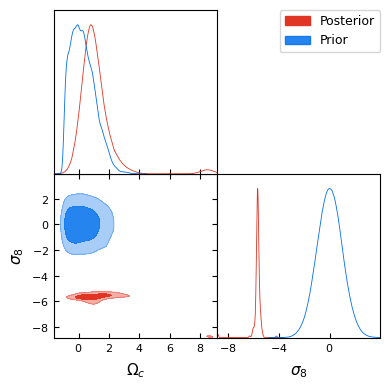

In [100]:
%matplotlib inline
# Diagnostics
numpyro.diagnostics.print_summary(post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains

# Triangle plot
post_samples_arr = np.array(list(post_samples.values())).T
prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in var_names]).T

post_samples_gd = MCSamples(samples=post_samples_arr, names=var_names, labels=var_labels)
prior_samples_gd = MCSamples(samples=prior_samples_arr, names=var_names, labels=var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
gd.triangle_plot(roots=[post_samples_gd, prior_samples_gd],
                 markers={'Omega_c':Omega_c, 'sigma8': sigma8}, # TODO fiducial cosmology
                 filled=True, 
                 legend_labels=["Posterior", "Prior"])

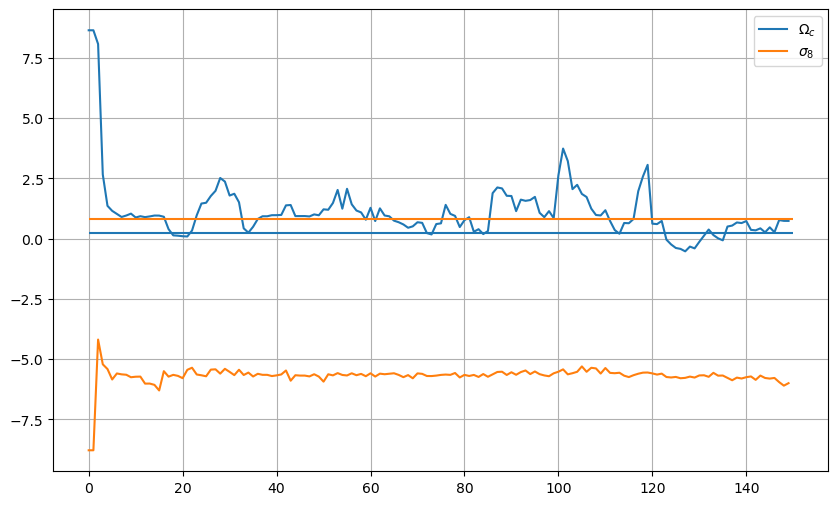

In [101]:
plt.figure(figsize=(10,6))
plt.plot(post_samples_arr, label=["$"+label+"$" for label in var_labels])
plt.hlines([Omega_c, sigma8], xmin=0, xmax=len(post_samples_arr), colors=["C0", "C1"])
plt.legend(), plt.grid();

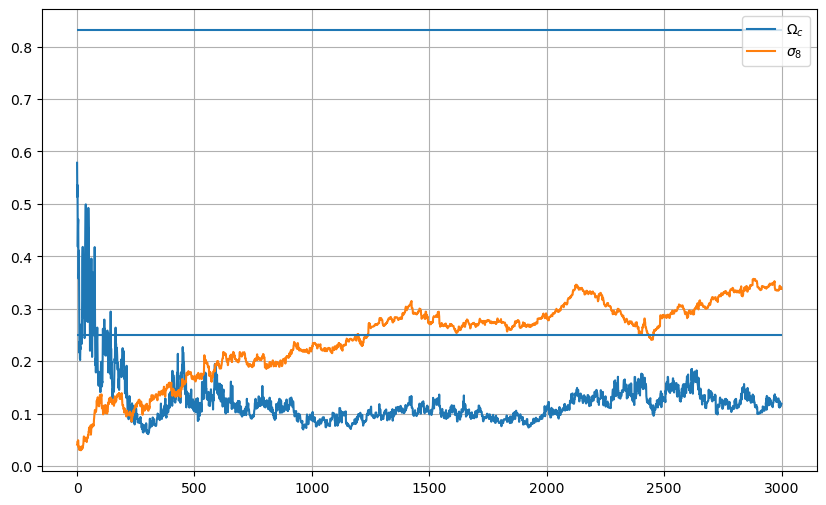

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(post_samples_arr, label=["$"+label+"$" for label in var_labels])
plt.hlines([Omega_c, sigma8], xmin=0, xmax=len(post_samples_arr))
plt.legend(), plt.grid();